# Import librarii si date

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px

import datetime as dt
import tensorflow as tf
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, r2_score
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.python.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from xgboost import XGBRegressor


Descarcam preturile zilnice de inchidere Intel din ultimii 7 ani



In [81]:
start_date="2018-01-01"
end_date="2024-05-01"
ticker = 'INTC'
data = pd.DataFrame()
data= yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [82]:
data

Price,Close,High,Low,Open,Volume
Ticker,INTC,INTC,INTC,INTC,INTC
Date,,,,,
2018-01-02,39.330383,39.372361,38.793106,38.935822,23370800
2018-01-03,37.995583,38.793104,36.643997,38.171879,116479000
2018-01-04,37.298813,37.483503,35.838088,36.534872,89209100
2018-01-05,37.559048,37.903241,36.853871,37.298803,41824000
2018-01-08,37.559048,37.642996,36.904239,37.164484,33733800
...,...,...,...,...,...
2024-04-24,34.143841,34.816821,33.985493,34.500125,53261100
2024-04-25,34.747543,34.935581,34.143840,34.203222,66549400


In [83]:
print(data['Close'].count())

Ticker
INTC    1592
dtype: int64


Graficul seriei de timp


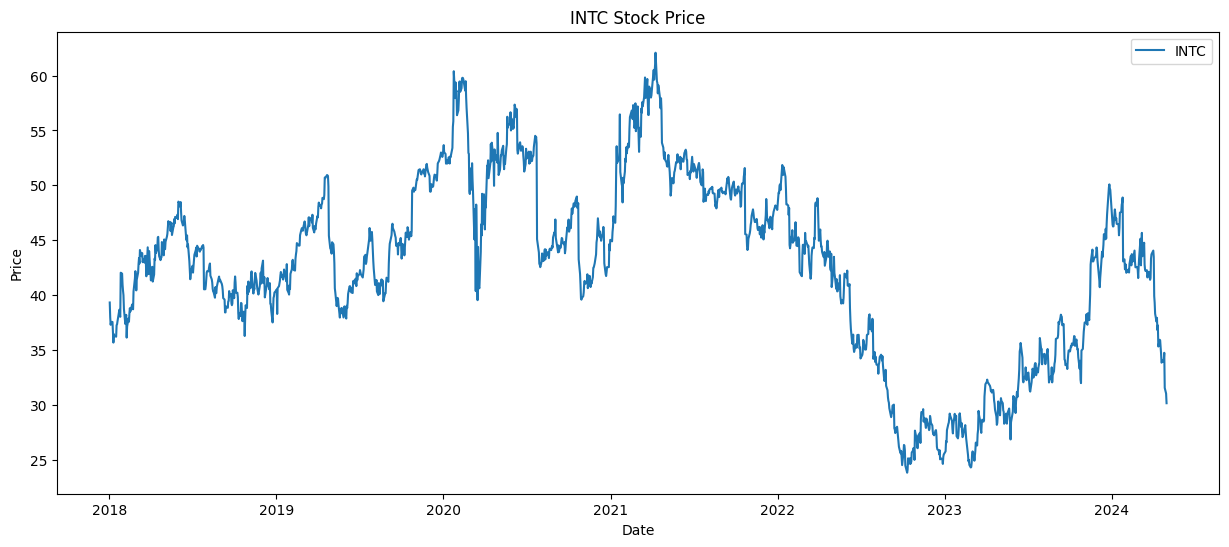

In [84]:
print('Graficul seriei de timp')
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Close'], label=ticker)
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# ARIMA
În aceasta sectiune, voi analiza si crea o prognoza pentru seria de timp folosind modelul ARIMA (AutoRegressive Integrated Moving Average), una dintre cele mai utilizate metode în econometrie pentru previziuni pe baza datelor istorice.

In [85]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['Close'])
print('Testul nu este semnificativ statistic, deci seria este nestationara')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

Testul nu este semnificativ statistic, deci seria este nestationara
ADF Statistic: -2.131442
p-value: 0.232061


In [86]:
# Calcul diferențiere ordinul 1
data['Close_diff'] = data['Close'].diff()
data.dropna(inplace=True)

In [87]:
# Test ADF pe seria diferențiată
result_diff = adfuller(data['Close_diff'])
print('\nTestul ADF pentru seria diferențiată de arata ca seria este stationara')
print(f'ADF Statistic: {result_diff[0]:.6f}')
print(f'p-value: {result_diff[1]:.6f}')


Testul ADF pentru seria diferențiată de arata ca seria este stationara
ADF Statistic: -13.160301
p-value: 0.000000


Graficul seriri diferentiate. Remarcam volatilitate in prima parte a anului 2020


Text(0.5, 1.0, 'Difference 1')

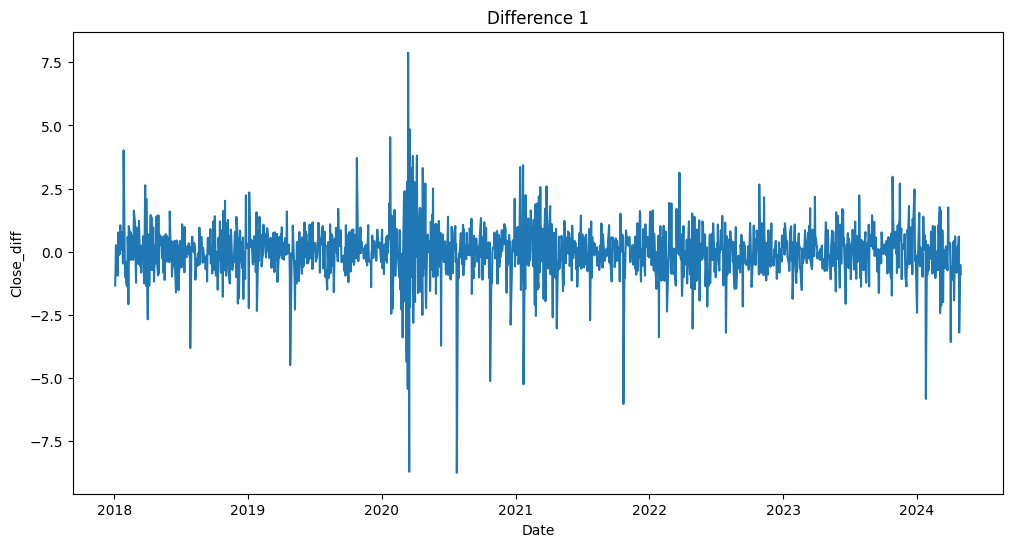

In [88]:
print('Graficul seriri diferentiate. Remarcam volatilitate in prima parte a anului 2020')
plt.figure(figsize=(12,6))
g = sns.lineplot(data=data, x='Date',y='Close_diff')
g.set_title('Difference 1')

Distributia seriei initiale


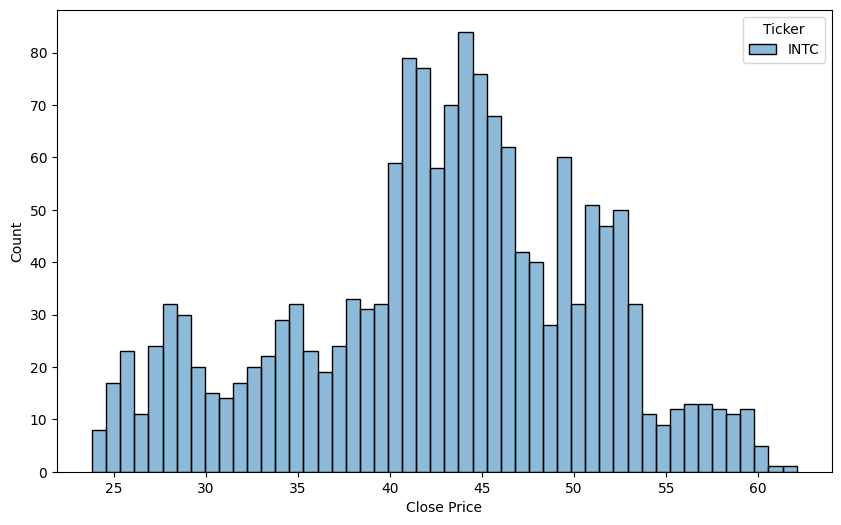

In [89]:
print('Distributia seriei initiale')
plt.figure(figsize=(10, 6))
sns.histplot(data['Close'], bins=50)
plt.xlabel('Close Price')
plt.ylabel('Count')
plt.show()

Distributia seriei diferentiate este normala


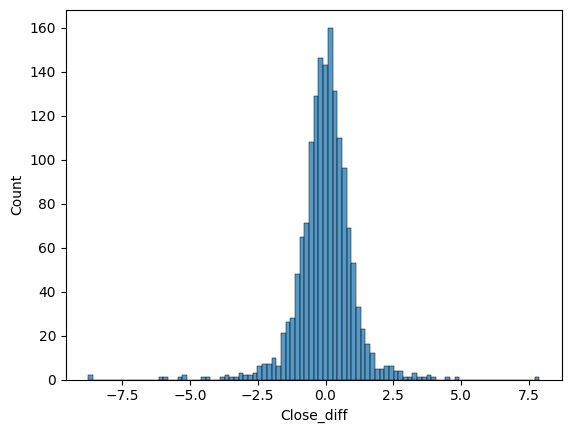

In [90]:
sns.histplot(data=data, x='Close_diff')
print('Distributia seriei diferentiate este normala')

In [91]:
# Impartirea pe train si test
length_test = 350
train = data[0:-length_test].copy()
test = data[-length_test:].copy()

print("Impartire pe train si test")
print("Training data shape:", train.shape)
print("Testing data shape:", test.shape)

Impartire pe train si test
Training data shape: (1241, 6)
Testing data shape: (350, 6)


ACF PACF

Observam descrestere lenta pentru MA, deci nestationaritate. PACF semnificativ pana la lagul 3, posibil AR(3)


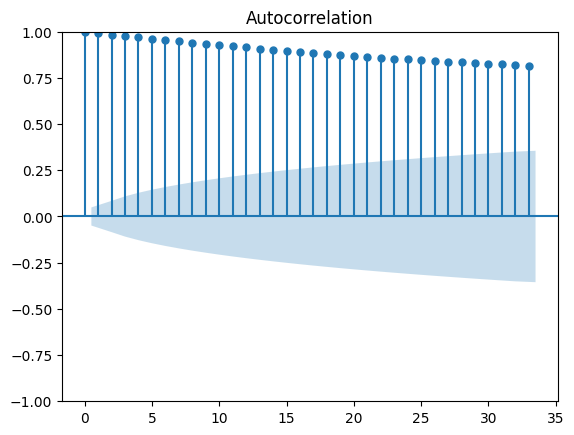

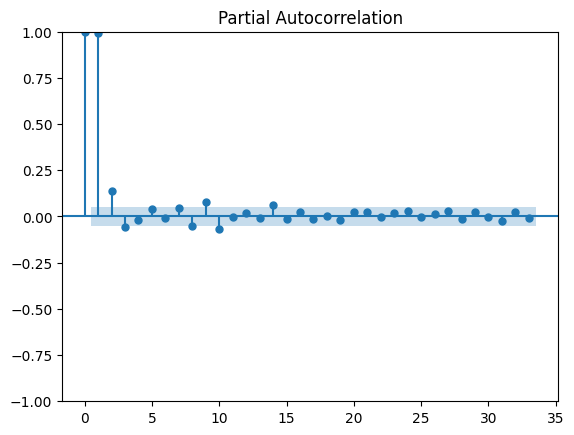

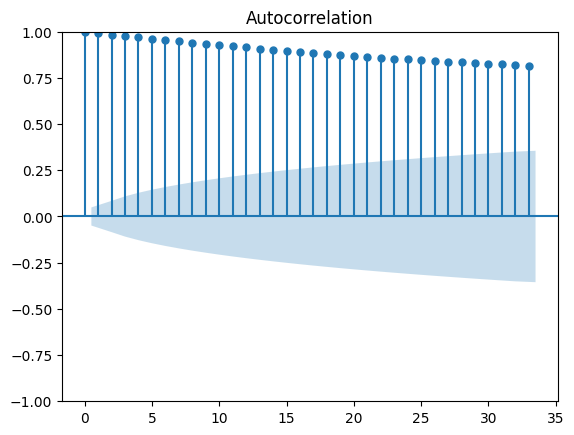

In [92]:
print('Observam descrestere lenta pentru MA, deci nestationaritate. PACF semnificativ pana la lagul 3, posibil AR(3)')
plot_pacf(data['Close'])
plot_acf(data['Close'])

Observam ca scaderea ACF s-a remediat pentru seria diferentiata (posibil MA(2)). PACF semnificativ pana la lagul 2, posibil AR(2)


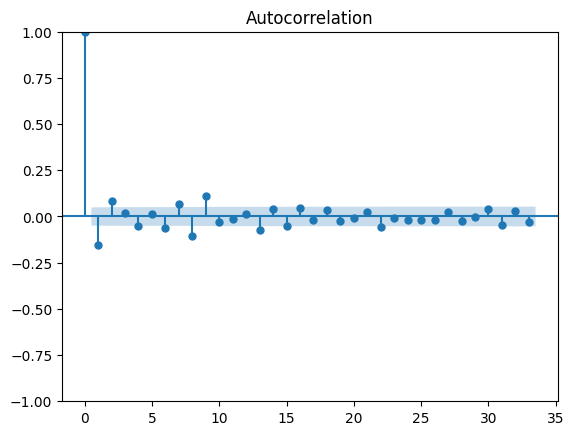

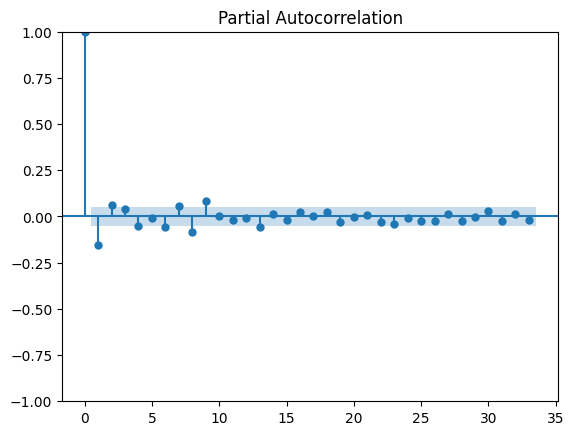

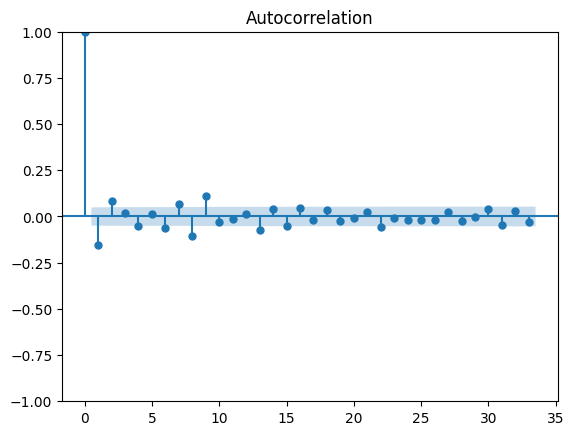

In [93]:
print('Observam ca scaderea ACF s-a remediat pentru seria diferentiata (posibil MA(2)). PACF semnificativ pana la lagul 2, posibil AR(2)')
plot_pacf(data['Close_diff'])
plot_acf(data['Close_diff'])

In [94]:
#Implementam modelul ARIMA

def run_arima_forecast(data, p, d, q, length_test=350):
    # Impartirea pe train si test
    train = data[0:-length_test].copy()
    test = data[-length_test:].copy()

    print("Training data shape:", train.shape)
    print("Testing data shape:", test.shape)

    # Create and fit the ARIMA model
    manual_arima_model = ARIMA(train['Close'], order=(p, d, q))
    manual_arima_result = manual_arima_model.fit()

    print(manual_arima_result.summary())

    # Prognoza pe setul de antrenament (in-sample)
    manual_arima_pred_train = manual_arima_result.predict(start=0, end=len(train)-1)
    train['Manual_ARIMA_Predictions'] = manual_arima_pred_train.values

    # Forecast on the test set (out-of-sample)
    start_index = len(train)
    end_index = len(train) + len(test) - 1
    manual_arima_pred_test = manual_arima_result.predict(start=start_index, end=end_index)

    # Add predictions to the test DataFrame
    test['Manual_ARIMA_Predictions'] = manual_arima_pred_test.values

    # Plot the results
    plt.figure(figsize=(15, 6))
    plt.plot(train.index, train['Close'], label='Training Data')
    plt.plot(test.index, test['Close'], label='Actual Test Data')
    plt.plot(train.index, train['Manual_ARIMA_Predictions'], label='Manual ARIMA In-Sample Forecast', linestyle='--')
    plt.plot(test.index, test['Manual_ARIMA_Predictions'], label=f'Manual ARIMA Out-of-Sample Forecast ({p},{d},{q})')
    plt.title(f'{ticker} Stock Price Forecast (ARIMA ({p},{d},{q}))')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Evaluate the model
    mae = mean_absolute_error(test['Close'], test['Manual_ARIMA_Predictions'])
    mape = mean_absolute_percentage_error(test['Close'], test['Manual_ARIMA_Predictions'])

    print(f"Manual ARIMA Model MAE (Test): {mae:.2f}")
    print(f"Manual ARIMA Model MAPE (Test): {mape:.2f}")

    return manual_arima_result


Training data shape: (1241, 6)
Testing data shape: (350, 6)
                               SARIMAX Results                                
Dep. Variable:                   INTC   No. Observations:                 1241
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1833.783
Date:                Wed, 04 Jun 2025   AIC                           3673.566
Time:                        14:28:40   BIC                           3688.935
Sample:                             0   HQIC                          3679.346
                               - 1241                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3389      0.090     -3.776      0.000      -0.515      -0.163
ma.L1          0.1507      0.096      1.578      0.115      -0.037     

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

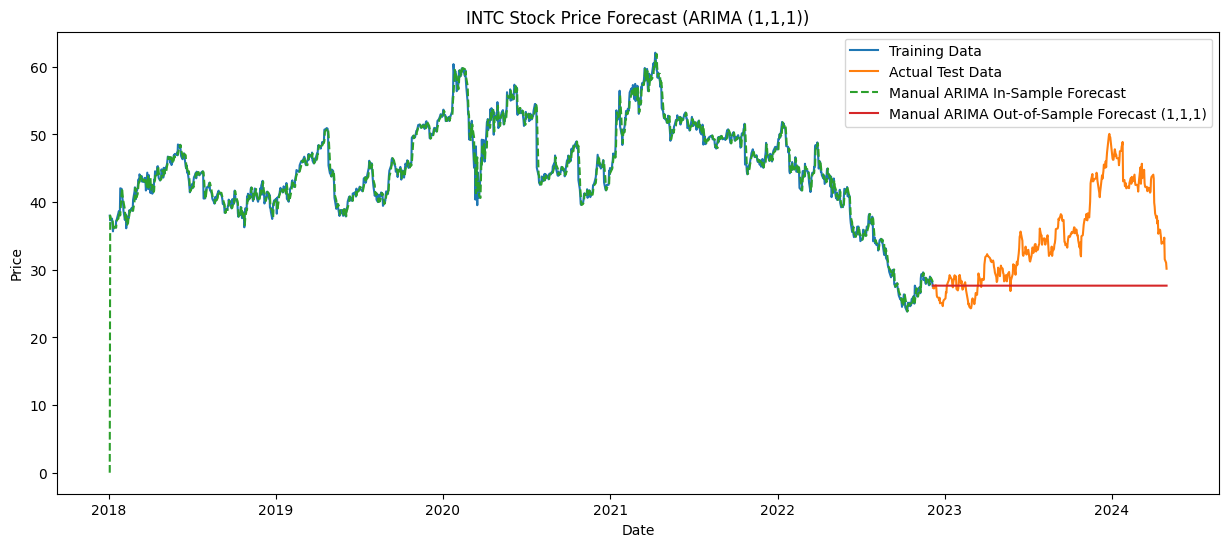

Manual ARIMA Model MAE (Test): 7.65
Manual ARIMA Model MAPE (Test): 0.20


In [95]:
run_arima_forecast(data, p=1, d=1, q=1, length_test=350)

In [96]:
%%time
warnings.filterwarnings("ignore")

p_values = range(0, 11)
d_values = [1] # Based on the previous analysis showing d=1 makes the series stationary
q_values = range(0, 11)

results = []

for p in p_values:
  for d in d_values:
    for q in q_values:
      try:
        # Split data to get train and test sets within the loop
        length_test = 350
        train = data[0:-length_test].copy()
        test = data[-length_test:].copy()

        model = ARIMA(train['Close'], order=(p, d, q))
        model_fit = model.fit()

        start_index = len(train)
        end_index = len(train) + len(test) - 1
        predictions = model_fit.predict(start=start_index, end=end_index)

        mape = mean_absolute_percentage_error(test['Close'], predictions)

        print(f"ARIMA({p},{d},{q}) - MAPE: {mape:.2f}")
        results.append({'model': f'ARIMA({p},{d},{q})', 'mape': mape})
      except:
        continue
print('Vom incerca mai multe combinatii de hiperparametrii pentru modelul ARIMA, si il vom alege pe acela cu cel mai mic MAPE')

ARIMA(0,1,0) - MAPE: 0.20
ARIMA(0,1,1) - MAPE: 0.20
ARIMA(0,1,2) - MAPE: 0.20
ARIMA(0,1,3) - MAPE: 0.20
ARIMA(0,1,4) - MAPE: 0.20
ARIMA(0,1,5) - MAPE: 0.20
ARIMA(0,1,6) - MAPE: 0.20
ARIMA(0,1,7) - MAPE: 0.20
ARIMA(0,1,8) - MAPE: 0.20
ARIMA(0,1,9) - MAPE: 0.20
ARIMA(0,1,10) - MAPE: 0.20
ARIMA(1,1,0) - MAPE: 0.20
ARIMA(1,1,1) - MAPE: 0.20
ARIMA(1,1,2) - MAPE: 0.20
ARIMA(1,1,3) - MAPE: 0.20
ARIMA(1,1,4) - MAPE: 0.20
ARIMA(1,1,5) - MAPE: 0.20
ARIMA(1,1,6) - MAPE: 0.20
ARIMA(1,1,7) - MAPE: 0.20
ARIMA(1,1,8) - MAPE: 0.20
ARIMA(1,1,9) - MAPE: 0.20
ARIMA(1,1,10) - MAPE: 0.20
ARIMA(2,1,0) - MAPE: 0.20
ARIMA(2,1,1) - MAPE: 0.20
ARIMA(2,1,2) - MAPE: 0.20
ARIMA(2,1,3) - MAPE: 0.20
ARIMA(2,1,4) - MAPE: 0.19
ARIMA(2,1,5) - MAPE: 0.20
ARIMA(2,1,6) - MAPE: 0.20
ARIMA(2,1,7) - MAPE: 0.20
ARIMA(2,1,8) - MAPE: 0.20
ARIMA(2,1,9) - MAPE: 0.20
ARIMA(2,1,10) - MAPE: 0.20
ARIMA(3,1,0) - MAPE: 0.20
ARIMA(3,1,1) - MAPE: 0.20
ARIMA(3,1,2) - MAPE: 0.20
ARIMA(3,1,3) - MAPE: 0.20
ARIMA(3,1,4) - MAPE: 0.12
ARIMA(3,1

In [97]:
# Top 10 models by MAPE
results_df = pd.DataFrame(results)
top_10_models = results_df.sort_values(by='mape').head(10)

print("\nTop 10 ARIMA Models by MAPE:")
top_10_models


Top 10 ARIMA Models by MAPE:


,model,mape
92,"ARIMA(8,1,4)",0.117514
37,"ARIMA(3,1,4)",0.119520
76,"ARIMA(6,1,10)",0.167301
119,"ARIMA(10,1,9)",0.167896
97,"ARIMA(8,1,9)",0.172517
65,"ARIMA(5,1,10)",0.173962
80,"ARIMA(7,1,3)",0.178893
38,"ARIMA(3,1,5)",0.179679
109,"ARIMA(9,1,10)",0.182183
86,"ARIMA(7,1,9)",0.182499


Cel mai bun model gasit a fost ARIMA(8,1,4). Predictia pare sa urmeze trendul ascendent al ultimului an, dar nu este reprezentativ
Training data shape: (1241, 6)
Testing data shape: (350, 6)
                               SARIMAX Results                                
Dep. Variable:                   INTC   No. Observations:                 1241
Model:                 ARIMA(8, 1, 4)   Log Likelihood               -1826.677
Date:                Wed, 04 Jun 2025   AIC                           3679.355
Time:                        14:32:46   BIC                           3745.952
Sample:                             0   HQIC                          3704.401
                               - 1241                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.77

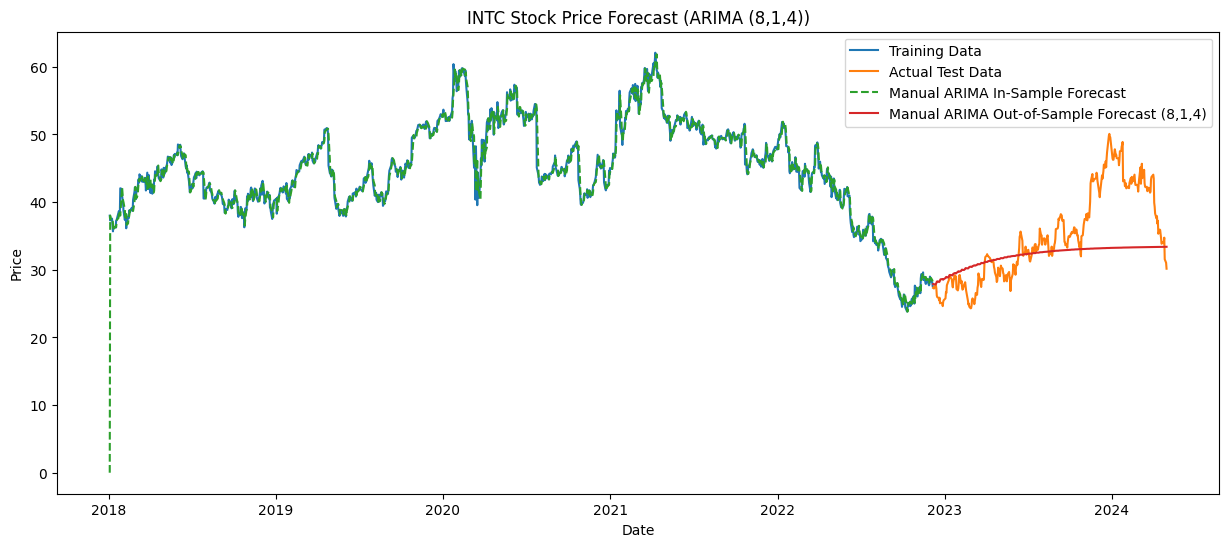

Manual ARIMA Model MAE (Test): 4.52
Manual ARIMA Model MAPE (Test): 0.12


In [98]:
print('Cel mai bun model gasit a fost ARIMA(8,1,4). Predictia pare sa urmeze trendul ascendent al ultimului an, dar nu este reprezentativ')
run_arima_forecast(data, p=8, d=1, q=4, length_test=350)

# LSTM
In această secțiune, vom explora rețelele LSTM (Long Short-Term Memory). Spre deosebire de ARIMA, modelele LSTM pot capta relații neliniare și modele complexe în date, fără presupuneri restrictive (ex. staționaritate).

In [99]:
#Prepare data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [100]:
prediction_days = 1
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [101]:
#Build the model
model = Sequential()
model.add(LSTM(10, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.3))

model.add(LSTM(units=10))
model.add(Dropout(0.3))

model.add(Dense(units=1))
print('Am creat modelul LSTM cu 10 neuroni, in 2 etape, si o rata de dropout de 0.3 (se vor uita 30% din datele de antrenare)')

Am creat modelul LSTM cu 10 neuroni, in 2 etape, si o rata de dropout de 0.3 (se vor uita 30% din datele de antrenare)


In [102]:
print('Rulam modelul creat mai sus pe o perioada de 10 epoci; observam cum MSE se micsoreaza')
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs=10, batch_size=10)

Rulam modelul creat mai sus pe o perioada de 10 epoci; observam cum MSE se micsoreaza
Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1909
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0310
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0241
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0200
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0164
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0134
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0112
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0091
Epoch 10/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0082


In [103]:
test_start = data.index[-length_test]
test_end = data.index[-1]

In [104]:
test_data = data.loc[test_start:test_end].copy()
actual_prices = test_data['Close'].values
actual = pd.DataFrame(actual_prices)
actual.rename(columns = {0: 'Actual_prices'}, inplace=True)
actual

,Actual_prices
0,27.317991
1,27.424059
2,27.231203
3,27.665131
4,27.703701
...,...
345,34.143841
346,34.747543
347,31.550890
348,31.036257


In [105]:
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

In [106]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [107]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
     x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [108]:
predicted_prices = model.predict(x_test)
predicted_prices

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


array([[0.21046546],
       [0.16355908],
       [0.16523534],
       [0.16219191],
       [0.16906723],
       [0.16968317],
       [0.16249543],
       [0.14594743],
       [0.14259303],
       [0.14070827],
       [0.1356743 ],
       [0.14128733],
       [0.12900595],
       [0.13069856],
       [0.12858388],
       [0.12299669],
       [0.13239789],
       [0.13553126],
       [0.13984114],
       [0.15377414],
       [0.15199015],
       [0.16968317],
       [0.17870298],
       [0.18074751],
       [0.18725047],
       [0.19432244],
       [0.19141774],
       [0.18327533],
       [0.17091742],
       [0.16493016],
       [0.17729245],
       [0.19399893],
       [0.1883691 ],
       [0.1848616 ],
       [0.19109593],
       [0.16098002],
       [0.1578137 ],
       [0.16249543],
       [0.17495051],
       [0.19270673],
       [0.19480813],
       [0.17447704],
       [0.18018001],
       [0.16744034],
       [0.15958849],
       [0.16065851],
       [0.17227682],
       [0.173

In [109]:
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1,1))
predicted_prices

array([[31.876076],
       [30.081455],
       [30.14559 ],
       [30.02915 ],
       [30.292196],
       [30.315762],
       [30.040762],
       [29.407642],
       [29.279303],
       [29.207193],
       [29.014595],
       [29.229347],
       [28.759468],
       [28.824226],
       [28.74332 ],
       [28.529556],
       [28.889242],
       [29.009123],
       [29.174017],
       [29.707088],
       [29.638834],
       [30.315762],
       [30.660856],
       [30.739079],
       [30.987879],
       [31.25845 ],
       [31.147318],
       [30.835793],
       [30.362984],
       [30.133913],
       [30.60689 ],
       [31.246073],
       [31.030678],
       [30.896482],
       [31.135006],
       [29.982782],
       [29.86164 ],
       [30.040762],
       [30.517288],
       [31.196634],
       [31.27703 ],
       [30.499172],
       [30.717365],
       [30.229952],
       [29.929544],
       [29.970482],
       [30.414995],
       [30.469067],
       [30.595839],
       [30.206207],


In [110]:
predicted = pd.DataFrame(predicted_prices)
predicted
predicted.rename(columns= {0: 'Predicted_prices'}, inplace=True)
predicted

,Predicted_prices
0,31.876076
1,30.081455
2,30.145590
3,30.029150
4,30.292196
...,...
345,34.520210
346,34.682064
347,35.136112
348,32.819736


Diferenta dintre preturile prezise, si setul de testare. Observam ca modelul a reusit sa prezica cu o acuratete mare, dar remarcam o supraestimare pentru primele 50 de zile


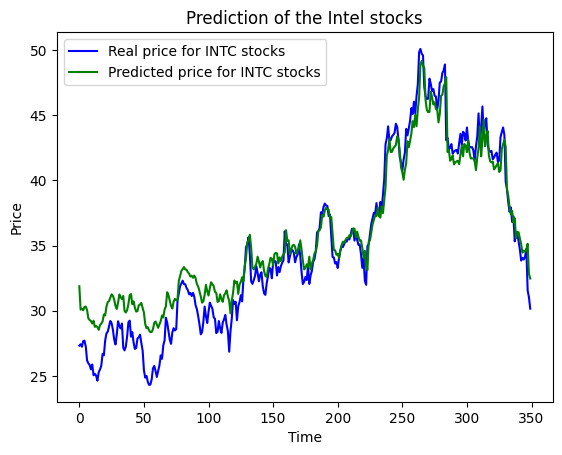

In [111]:
print('Diferenta dintre preturile prezise, si setul de testare. Observam ca modelul a reusit sa prezica cu o acuratete mare, dar remarcam o supraestimare pentru primele 50 de zile')
plt.plot(actual_prices, color = 'blue', label = 'Real price for INTC stocks')
plt.plot(predicted_prices, color = 'green', label = 'Predicted price for INTC stocks')
plt.title('Prediction of the Intel stocks')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [112]:
# Calculate R2 for train data
y_train_pred = model.predict(x_train)
y_train_pred_inv = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
r2_train = r2_score(y_train_inv, y_train_pred_inv)
print(f"R2 training: {r2_train:.4f}")

# Calculate R2 for test data
r2_test = r2_score(actual_prices, predicted_prices)
print(f"R2 test : {r2_test:.4f}")

# Calculate Mean Absolute Percentage Error for test data
mape_test = mean_absolute_percentage_error(actual_prices, predicted_prices)
print(f"MAPE Test: {mape_test:.4f}")

print('Observam R2 mare pentru setul de antrenare, care se modifica foarte putin pe setul nostru de testare')

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R2 training: 0.9618
R2 test : 0.9211
MAPE Test: 0.0475
Observam R2 mare pentru setul de antrenare, care se modifica foarte putin pe setul nostru de testare


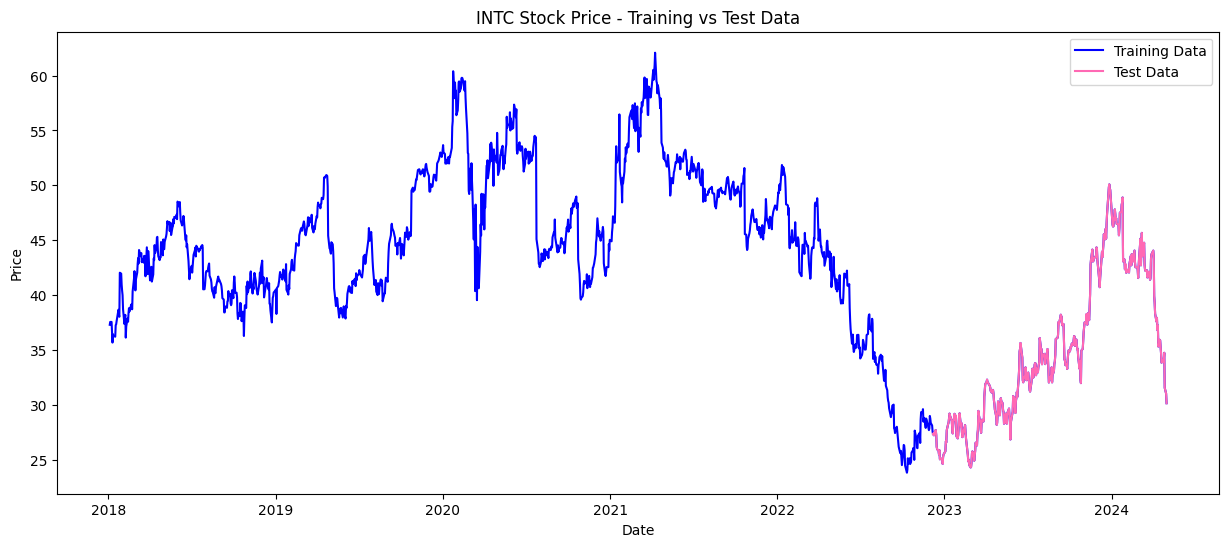

In [113]:
# Prepare data for plotting the training and test sets
train_data_length = len(data) - prediction_days

# Create an index for the training and test data
train_dates = data.index[prediction_days:]
test_dates = test_data.index

# Plot the training and test data
plt.figure(figsize=(15, 6))
plt.plot(train_dates, data['Close'][prediction_days:], label='Training Data', color='blue')
plt.plot(test_dates, test_data['Close'], label='Test Data', color='hotpink')

plt.title('INTC Stock Price - Training vs Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Intreaga serie, alaturi de predictia facuta


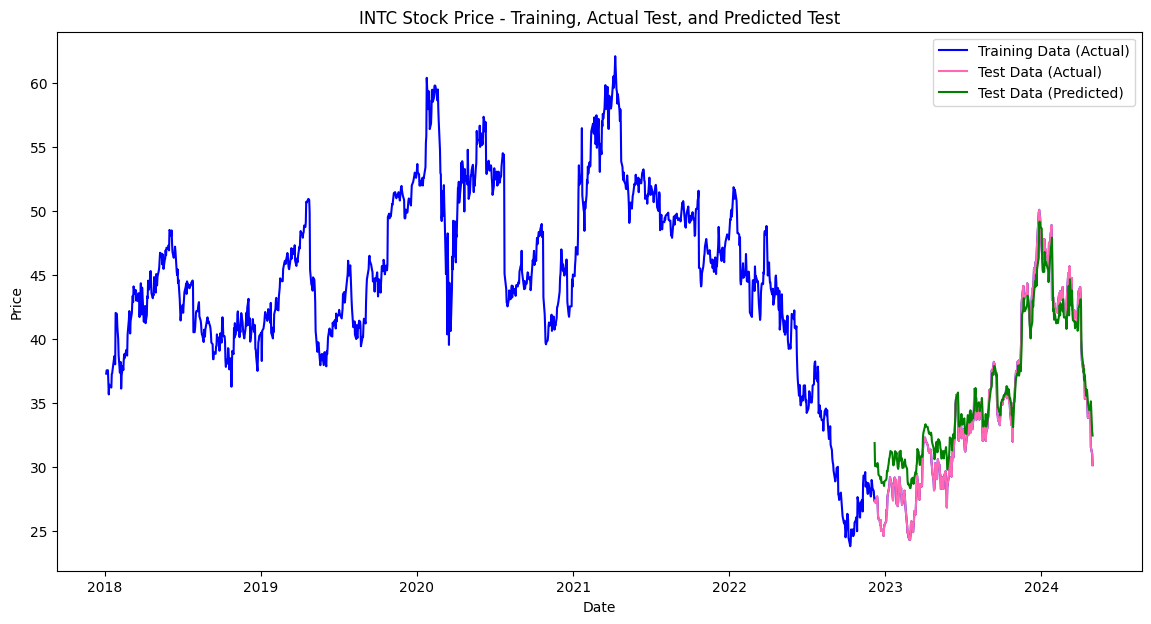

In [114]:
combined_index = data.index.tolist() + test_data.index.tolist()

# Prepare data for plotting
# Use the original training data
train_plot_data = data['Close'][prediction_days:]

# Use the actual test data
actual_test_plot_data = test_data['Close']

# Create a series for the predicted prices with the test data index
predicted_test_plot_data = pd.Series(predicted_prices.flatten(), index=test_data.index)

# Plot the training, actual test, and predicted test data on the same graph
print('Intreaga serie, alaturi de predictia facuta')

plt.figure(figsize=(14, 7))
plt.plot(train_plot_data.index, train_plot_data.values, label='Training Data (Actual)', color='blue')
plt.plot(actual_test_plot_data.index, actual_test_plot_data.values, label='Test Data (Actual)', color='hotpink')
plt.plot(predicted_test_plot_data.index, predicted_test_plot_data.values, label='Test Data (Predicted)', color='green')

plt.title('INTC Stock Price - Training, Actual Test, and Predicted Test')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# XGBoost
XGBoost (Extreme Gradient Boosting) este un algoritm de machine learning bazat pe arbori de decizie, folosit și în prognoza seriilor de timp datorită abilității de a gestiona relații neliniare și de a reduce overfitting-ul.

In [115]:
# Prepare data for XGBoost
# For time series, common features include lagged values and potentially moving averages
# Let's create some simple lagged features
def create_features(df, lag=1):
    df_new = pd.DataFrame(index=df.index)
    df_new['original'] = df['Close']
    for i in range(1, lag + 1):
        df_new[f'lag_{i}'] = df['Close'].shift(i)
    # Add potentially other features like day of the week, month etc.
    df_new['dayofweek'] = df.index.dayofweek
    df_new['month'] = df.index.month
    df_new['year'] = df.index.year
    return df_new

In [116]:
# Create features for the whole dataset
data_featured = create_features(data, lag=5) # Using lag=5 as an example

# Split the featured data into train and test based on the same split
train_featured = data_featured.loc[train.index].dropna()
test_featured = data_featured.loc[test.index].dropna()

In [117]:
# Define features (X) and target (y)
X_train = train_featured.drop('original', axis=1)
y_train = train_featured['original']

X_test = test_featured.drop('original', axis=1)
y_test = test_featured['original']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1236, 8)
y_train shape: (1236,)
X_test shape: (350, 8)
y_test shape: (350,)


In [118]:
# Initialize and train the XGBoost Regressor model
# You can tune parameters like n_estimators, learning_rate, max_depth etc.
xgb_model = XGBRegressor(n_estimators=100,
                         learning_rate=0.05,
                         max_depth=5,
                         random_state=42)

xgb_model.fit(X_train, y_train)

# Make predictions on the test set
xgb_predictions_test = xgb_model.predict(X_test)

In [119]:
# Create features specifically for the original training data index
train_featured_original = create_features(data.loc[train.index], lag=5).dropna()
X_train_original = train_featured_original.drop('original', axis=1)
y_train_original = train_featured_original['original'] # This is the actual train target

In [120]:
# Predict on the original training data features
xgb_predictions_train = xgb_model.predict(X_train_original)

In [121]:
# Evaluate the prediction on the train set (as requested, potentially for diagnostics)
rmse_train = np.sqrt(mean_squared_error(y_train_original, xgb_predictions_train))
mae_train = mean_absolute_error(y_train_original, xgb_predictions_train)
mape_train = mean_absolute_percentage_error(y_train_original, xgb_predictions_train)
r2_train = r2_score(y_train_original, xgb_predictions_train)

print("\nXGBoost Evaluation on Train Set:")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAPE: {mape_train:.4f}")
print(f"R2 Score: {r2_train:.4f}")


XGBoost Evaluation on Train Set:
RMSE: 0.7167
MAPE: 0.0119
R2 Score: 0.9898


Setul de test si preognoza. Pare a fi mai buna decat ARIMA; se remarca din nou o usoara supraestimare


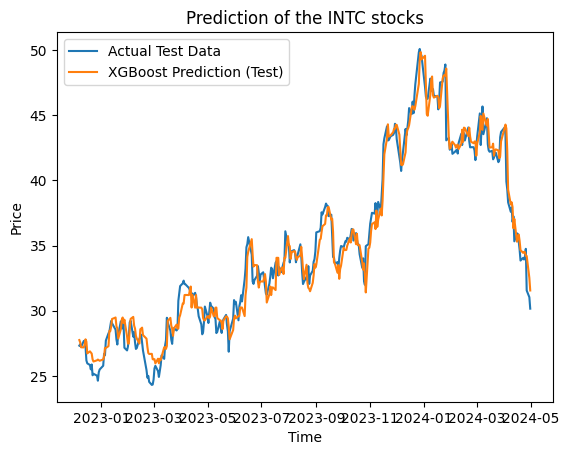

In [122]:
print('Setul de test si preognoza. Pare a fi mai buna decat ARIMA; se remarca din nou o usoara supraestimare')
plt.plot(y_test.index, y_test, label='Actual Test Data')
plt.plot(y_test.index, xgb_predictions_test, label='XGBoost Prediction (Test)')
plt.title('Prediction of the INTC stocks')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

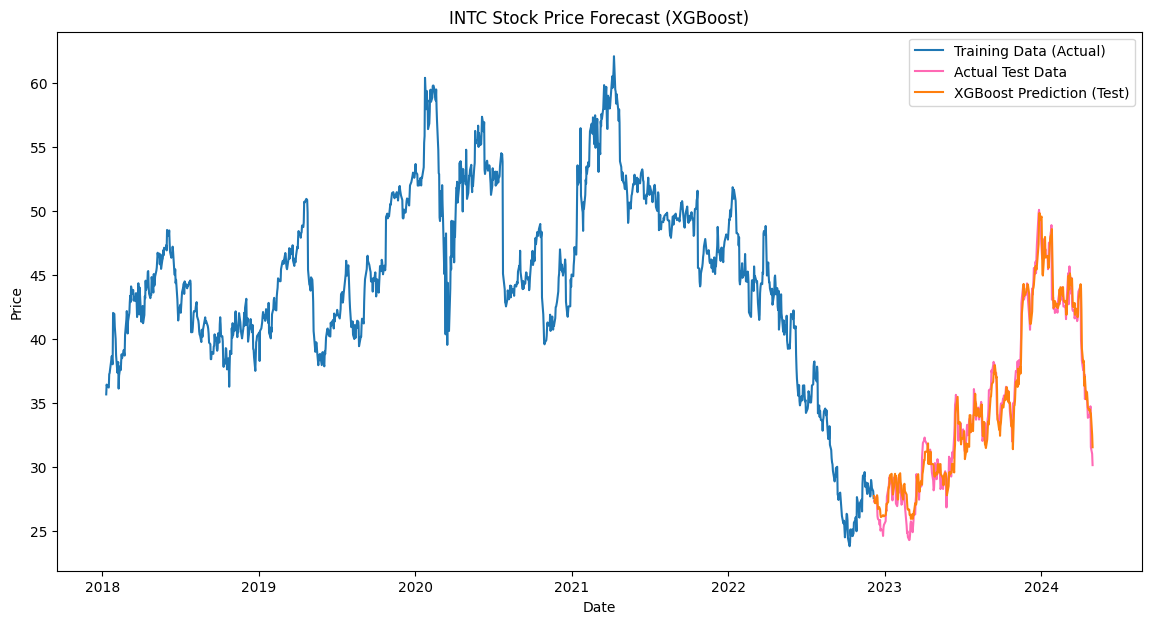

In [123]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(y_train_original.index, y_train_original, label='Training Data (Actual)')
plt.plot(y_test.index, y_test, label='Actual Test Data', color='hotpink')
plt.plot(y_test.index, xgb_predictions_test, label='XGBoost Prediction (Test)')
plt.title(f'{ticker} Stock Price Forecast (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Comparatia modelelor

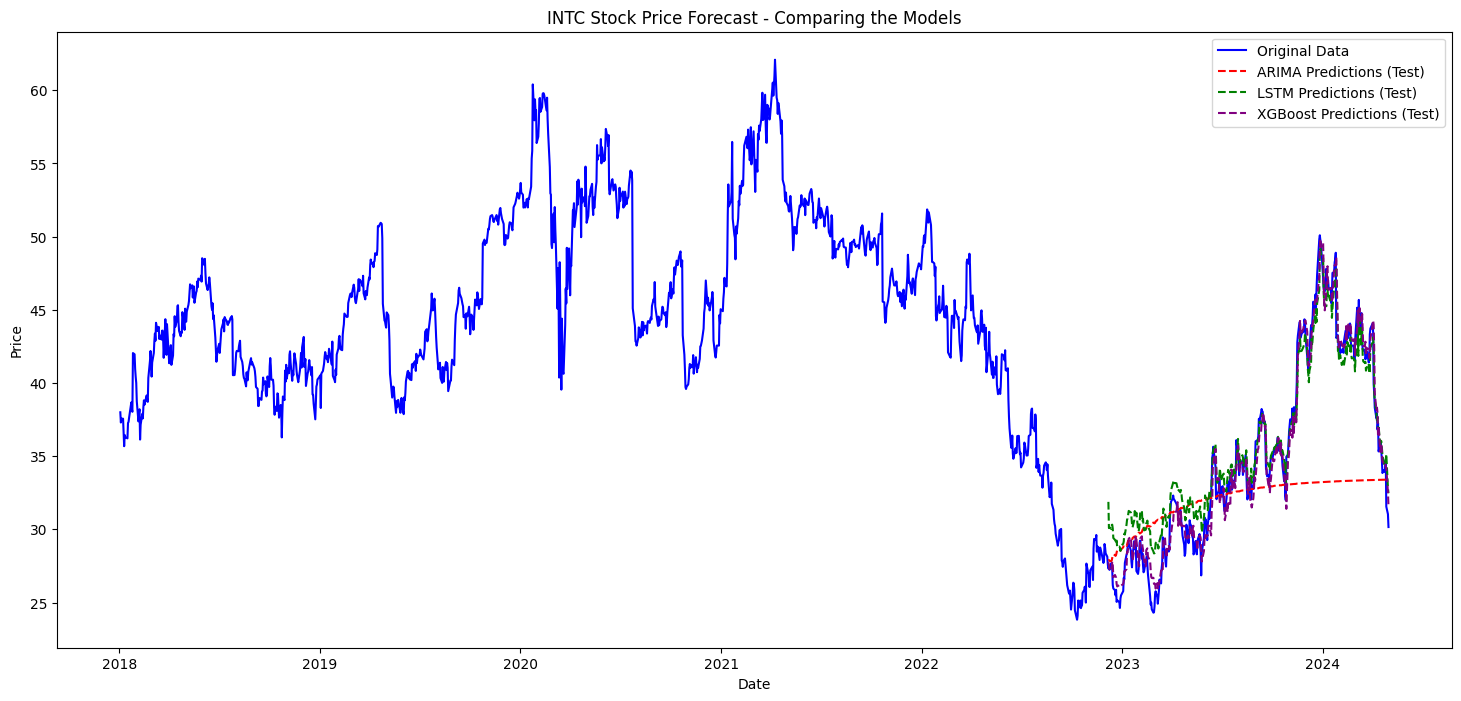

Predictiile tuturor modelelor folosite langa datele reale. Modelul XGBoost pare a fi cel mai potrivit, iar ARIMA este cel mai slab


In [124]:
length_test = 350
train_arima_plot = data[0:-length_test].copy()
test_arima_plot = data[-length_test:].copy()


model_arima_plot = ARIMA(train_arima_plot['Close'], order=(8, 1, 4))
model_fit_arima_plot = model_arima_plot.fit()

# Forecast on the test set
start_index_arima = len(train_arima_plot)
end_index_arima = len(train_arima_plot) + len(test_arima_plot) - 1
arima_predictions_test = model_fit_arima_plot.predict(start=start_index_arima, end=end_index_arima)

actual_data = pd.concat([train['Close'], test['Close']])

arima_predictions = pd.Series(arima_predictions_test.values, index=test_arima_plot.index)
lstm_predictions = pd.Series(predicted_prices.flatten(), index=test_data.index) # Use test_data index as calculated for LSTM
xgb_predictions = pd.Series(xgb_predictions_test, index=X_test.index)


# Plotting
plt.figure(figsize=(18, 8))

plt.plot(actual_data.index, actual_data.values, label='Original Data', color='blue')

plt.plot(arima_predictions.index, arima_predictions.values, label='ARIMA Predictions (Test)', linestyle='--', color='red')
plt.plot(lstm_predictions.index, lstm_predictions.values, label='LSTM Predictions (Test)', linestyle='--', color='green')
plt.plot(xgb_predictions.index, xgb_predictions.values, label='XGBoost Predictions (Test)', linestyle='--', color='purple')

plt.title(f'{ticker} Stock Price Forecast - Comparing the Models')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print('Predictiile tuturor modelelor folosite langa datele reale. Modelul XGBoost pare a fi cel mai potrivit, iar ARIMA este cel mai slab')

In [125]:
# Calculate R2 and MAPE for ARIMA on test set
arima_r2_test = r2_score(test_arima_plot['Close'], arima_predictions)
arima_mape_test = mean_absolute_percentage_error(test_arima_plot['Close'], arima_predictions)

# Calculate R2 and MAPE for LSTM on test set
# These were already calculated, just extracting them for display
lstm_r2_test = r2_score(actual_prices, predicted_prices)
lstm_mape_test = mean_absolute_percentage_error(actual_prices, predicted_prices)

# Calculate R2 and MAPE for XGBoost on test set
# These were already calculated, just extracting them for display
xgb_r2_test = r2_score(y_test, xgb_predictions_test)
xgb_mape_test = mean_absolute_percentage_error(y_test, xgb_predictions_test)


print("\n--- Model Performance on Test Set ---")
print(f"ARIMA (8,1,4) - R2: {arima_r2_test:.4f}, MAPE: {arima_mape_test:.4f}")
print(f"LSTM          - R2: {lstm_r2_test:.4f}, MAPE: {lstm_mape_test:.4f}")
print(f"XGBoost       - R2: {xgb_r2_test:.4f}, MAPE: {xgb_mape_test:.4f}")
print('\nModelul XGBoost este cel mai bun, cu un R2 de 97%, si cel mai mic MAPE')


--- Model Performance on Test Set ---
ARIMA (8,1,4) - R2: 0.1102, MAPE: 0.1175
LSTM          - R2: 0.9211, MAPE: 0.0475
XGBoost       - R2: 0.9712, MAPE: 0.0257

Modelul XGBoost este cel mai bun, cu un R2 de 97%, si cel mai mic MAPE
